In [789]:
# Start by importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time
import math
import pandas as pd
from rich import print



In [790]:
# Need a way to represent the graph easily so that the algorithm can be implemented
# I will use a dictionary tp represent the graph
# The keys will be the nodes and the values will be adjacent nodes
# The graph will be undirected and weighted

nodes = ['A', 'B', 'C', 'D', 'E', 'F']
edges = {
    ('A', 'B'): 3,
    ('A', 'D'): 1,
    ('A', 'C'): 6,
    ('B', 'C'): 5,
    ('B', 'D'): 9,
    ('C', 'D'): 7,
    ('C', 'F'): 5,
    ('D', 'E'): 2,
    ('E', 'F'): 3
}

In [791]:
# Need a way to print the graph so that it is easy to visualize using networkx
def print_graph(nodes, edges):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for k, v in edges.items():
        G.add_edge(k[0], k[1], weight=v)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()


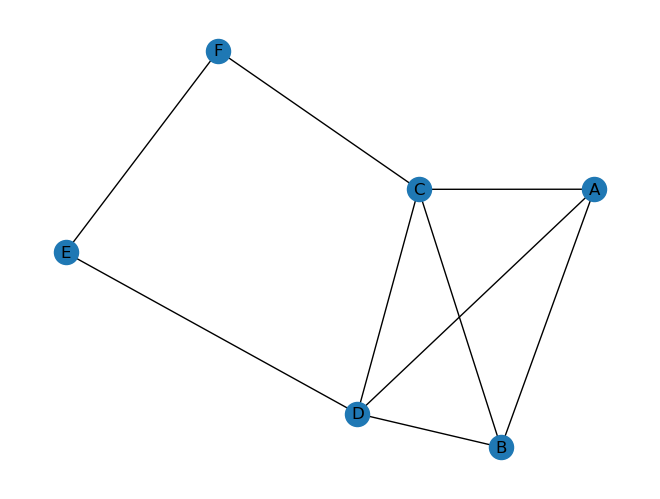

In [792]:
print_graph(nodes, edges)

In [793]:
current_node = 'A'
connected_nodes = [x for x in edges.keys() if current_node in x]

lowest_edge = min(connected_nodes, key=lambda x: edges[x])
print(connected_nodes)
print(lowest_edge)

[('A', 'B'), ('A', 'D'), ('A', 'C')]

('A', 'D')

In [794]:
# Now that i have a way to represent the graph, I can implement the algorithm
# The algorithm will take in a graph and return the minimum spanning tree

def boruvka(nodes, edges):
    # Initialize each node as a separate component
    sets = {x: i for i, x in enumerate(nodes)}
    mst = {}
    
    while len(set(sets.values())) > 1:
        # Store the minimum edge for each component
        min_edges = {}

        for edge in edges:
            node1, node2 = edge
            set1, set2 = sets[node1], sets[node2]

            # Check if it's a cross-component edge and if it's the smallest so far
            if set1 != set2:
                if set1 not in min_edges or edges[edge] < edges[min_edges[set1]]:
                    min_edges[set1] = edge
                if set2 not in min_edges or edges[edge] < edges[min_edges[set2]]:
                    min_edges[set2] = edge

        # Merge components and build the MST
        for edge in min_edges.values():
            node1, node2 = edge
            set1, set2 = sets[node1], sets[node2]

            # Merge the sets
            if set1 != set2:
                for k in sets:
                    if sets[k] == set2:
                        sets[k] = set1
                
                # Add the edge to the MST
                mst[edge] = edges[edge]

    return mst
                        

In [795]:
mst = boruvka(nodes, edges)

In [796]:
mst

{('A', 'D'): 1, ('A', 'B'): 3, ('B', 'C'): 5, ('E', 'F'): 3, ('D', 'E'): 2}

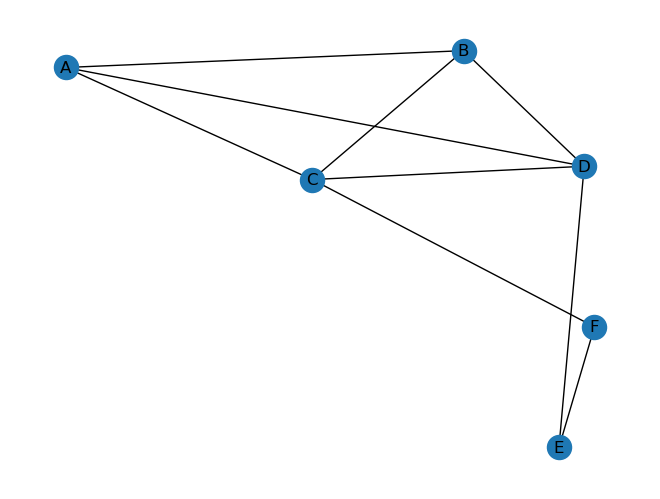

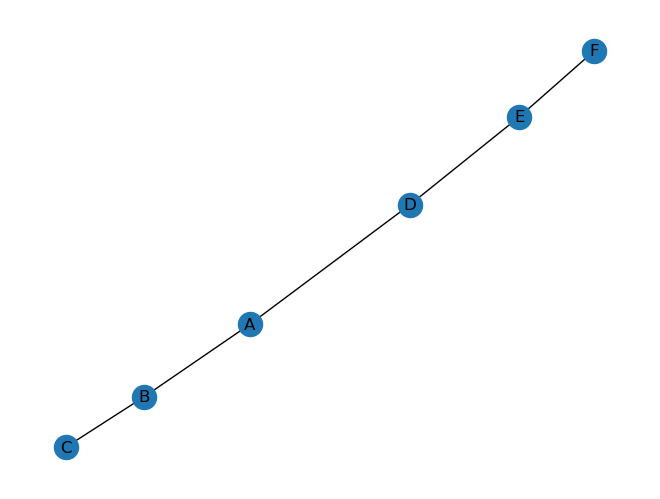

In [797]:
print_graph(nodes, edges)
print_graph(nodes, mst)

In [798]:
# Boruvka's Algorithm can also be used to create a perfect maze
# A perfect maze is a maze that has no loops and no isolated walls
# I will use the same algorithm, but I will change the graph so that it is a maze
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_maze(maze):
    # Assuming 'maze' is a 2D NumPy array where walls are represented by 1s and paths by 0s
    cmap = mcolors.ListedColormap(['white', 'black'])  # white for paths, black for walls
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap=cmap, interpolation='none')
    plt.axis('off')  # Turn off the axis
    plt.show()
    

In [799]:
# Need to initialise a graph that contains all of the points in the maze where the maze is a 2D numpy array where edges and nodes are 0s
import matplotlib.colors as mcolors

def apply_gradient(maze):
    """
    Apply a gradient to the path (2) in the maze.
    This function assumes a simple linear path for the sake of demonstration.
    """
    # Find the path cells
    path_indices = np.argwhere(maze == 2)

    # Create a gradient
    n = len(path_indices)
    gradient = np.linspace(0, 1, n)

    # Apply the gradient to the path cells
    for i, (r, c) in enumerate(path_indices):
        maze[r, c] = gradient[i] + 2  # Offset by 2 to distinguish from walls and open paths

    return maze

def plot_maze(maze):
    # Apply gradient
    gradient_maze = apply_gradient(maze.copy())

    # If there is just 1s and 0s in the maze, use a simple black and white colormap
    if np.array_equal(np.unique(maze), np.array([0, 1])):
        cmap = mcolors.ListedColormap(['white', 'black'])
    else:
        # Create a custom colormap
        # 0 -> white (open path), 1 -> black (walls), 2-3 -> gradient
        cmap = mcolors.LinearSegmentedColormap.from_list('maze_cmap', ['white', 'black', 'blue', 'red'])
        bounds = [0,1,2,3]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 10))
    plt.imshow(gradient_maze, cmap=cmap, interpolation='none')
    plt.axis('off')  # Turn off the axis
    plt.show()


size = 100
nodes = []

for i in range(0, size, 2):
    for j in range(0, size, 2):
        nodes.append((i, j))


# Initialise the edges
edges = {}

# get min and max x and y values
min_x = min([x[0] for x in nodes])
max_x = max([x[0] for x in nodes])
min_y = min([x[1] for x in nodes])
max_y = max([x[1] for x in nodes])

for node in nodes:
    x = node[0]
    y = node[1]
    # Get the adjacent nodes
    adjacent_nodes = [(x+2, y), (x-2, y), (x, y+2), (x, y-2)]
    # Remove the adjacent nodes that are not in the maze
    # Add the edges to the graph
    for adjacent_node in adjacent_nodes:
        if adjacent_node[0] >= min_x and adjacent_node[0] <= max_x and adjacent_node[1] >= min_y and adjacent_node[1] <= max_y:
            edges[(node, adjacent_node)] = random.randint(1, 10)

# print(nodes)
# print(edges)


In [800]:
maze = boruvka(nodes, edges)

In [801]:
def midpoint(x, y):
    return (x + y) // 2

def map_point(p):
    return (p[0] * 2, p[1] * 2)

def convert_to_np(nodes, mst, path=None):
    # need to convert the mst to a numpy array
    # need to get the min and max x and y values
    min_x = min([x[0] for x in nodes])
    max_x = max([x[0] for x in nodes])
    min_y = min([x[1] for x in nodes])
    max_y = max([x[1] for x in nodes])
    
    # need to create a numpy array of the correct size
    size_x = max_x - min_x + 1
    size_y = max_y - min_y + 1
    
    np_mst = np.zeros((size_x, size_y))
    
    
    for n1, n2 in mst:
        np_mst[n1] = 1
        np_mst[n2] = 1
        # need to get the midpoint between the two nodes
        mid_x = midpoint(n1[0], n2[0])
        mid_y = midpoint(n1[1], n2[1])
        np_mst[mid_x][mid_y] = 1        
        
        
    if path:
        # Need to add the path to the numpy array as 2
        for p in path:
            np_mst[p] = 2
        
        return np_mst
    else:
        return np_mst

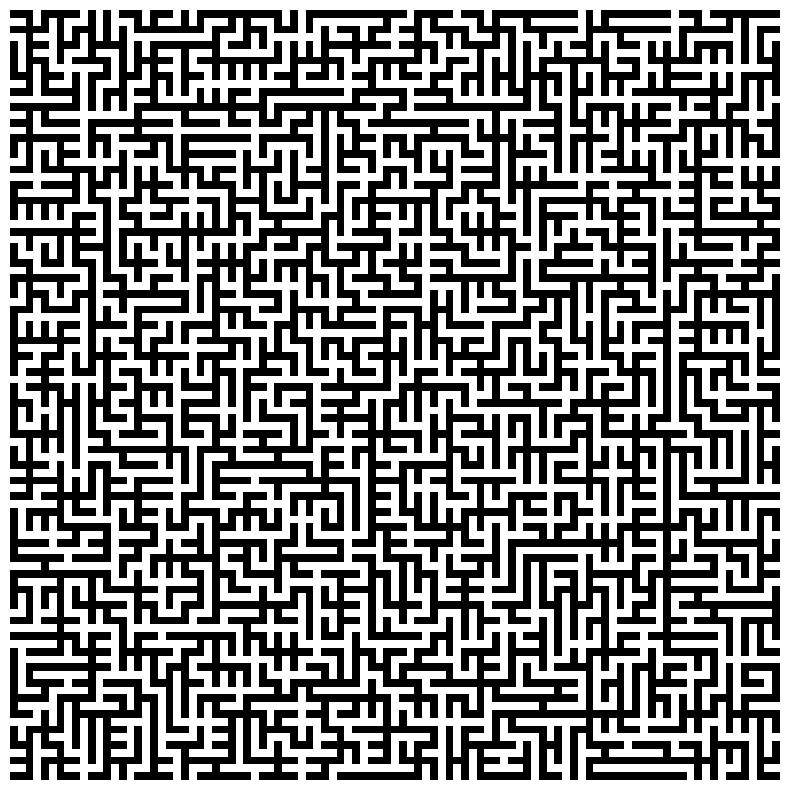

In [802]:
np_maze = convert_to_np(nodes, maze)

plot_maze(np_maze)

In [803]:
print(np_maze)


[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]

In [804]:
# Use dfs to find the path from the start to the end

def get_neighbours(v, maze):
    x = v[0]
    y = v[1]
    
    neighbours = []
    
    # Check if the node is on the edge of the maze
    if x == 0:
        # Node is on the left edge
        neighbours.append((x + 1, y))
    elif x == maze.shape[0] - 1:
        # Node is on the right edge
        neighbours.append((x - 1, y))
    else:
        # Node is not on the edge
        neighbours.append((x + 1, y))
        neighbours.append((x - 1, y))
        
    if y == 0:
        # Node is on the top edge
        neighbours.append((x, y + 1))
    elif y == maze.shape[1] - 1:
        # Node is on the bottom edge
        neighbours.append((x, y - 1))
    else:
        # Node is not on the edge
        neighbours.append((x, y + 1))
        neighbours.append((x, y - 1))
        
    return neighbours

def bfs(in_maze):
    maze = in_maze.copy()
    Q = []
    
    start = (0, 0)
    end = (maze.shape[0] - 1, maze.shape[1] - 1)
    
    Q.append(start)
    
    prev = {}
    
    while len(Q) > 0:
        v = Q.pop(0)
        
        if v == end:
            return trace_path(prev, end, start)
        
        for n in get_neighbours(v, maze):
            if maze[n] == 1:
                Q.append(n)
                maze[n] = maze[v] - 1
                prev[n] = v
    
    return None

def trace_path(prev, end, start):
    path = [start]
    current = end
    
    while current != start:
        path.append(current)
        current = prev[current]
        
        
    path.append(current)
    
    return path[::-1]

path = bfs(np_maze)

[[2. 2. 2. ... 1. 1. 1.]
 [0. 0. 2. ... 0. 0. 0.]
 [1. 1. 2. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 2. 1. 1.]
 [0. 0. 1. ... 2. 0. 0.]
 [1. 1. 1. ... 2. 2. 2.]]

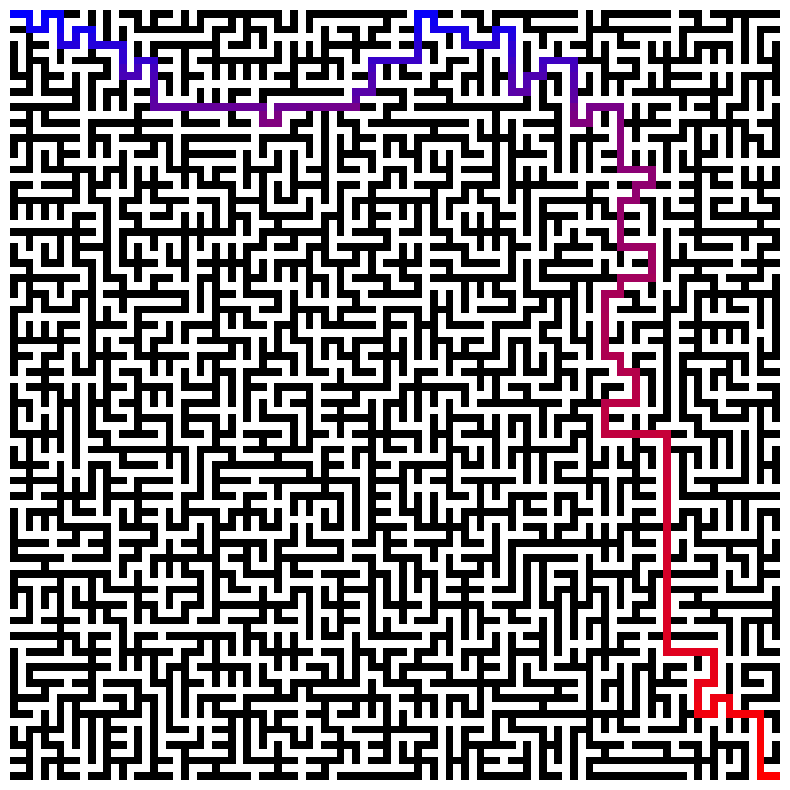

In [805]:
np_maze_with_path = convert_to_np(nodes, maze, path=path)

print(np_maze_with_path)

plot_maze(np_maze_with_path)